In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from scipy import stats
import seaborn as sns
from scipy.special import kl_div
import os
from model_structure import get_preprocessing_transforms,get_resnet_model,BCNN, train_model, evaluate_model

In [ ]:
MODEL_NAME = "pretrained" # "my" or "pretrained"
THE_CLASS = 1 # 0 cat or squirrel, 1 dog
CLASSES = { 
    0: 'cat',
    1: 'dog'
}

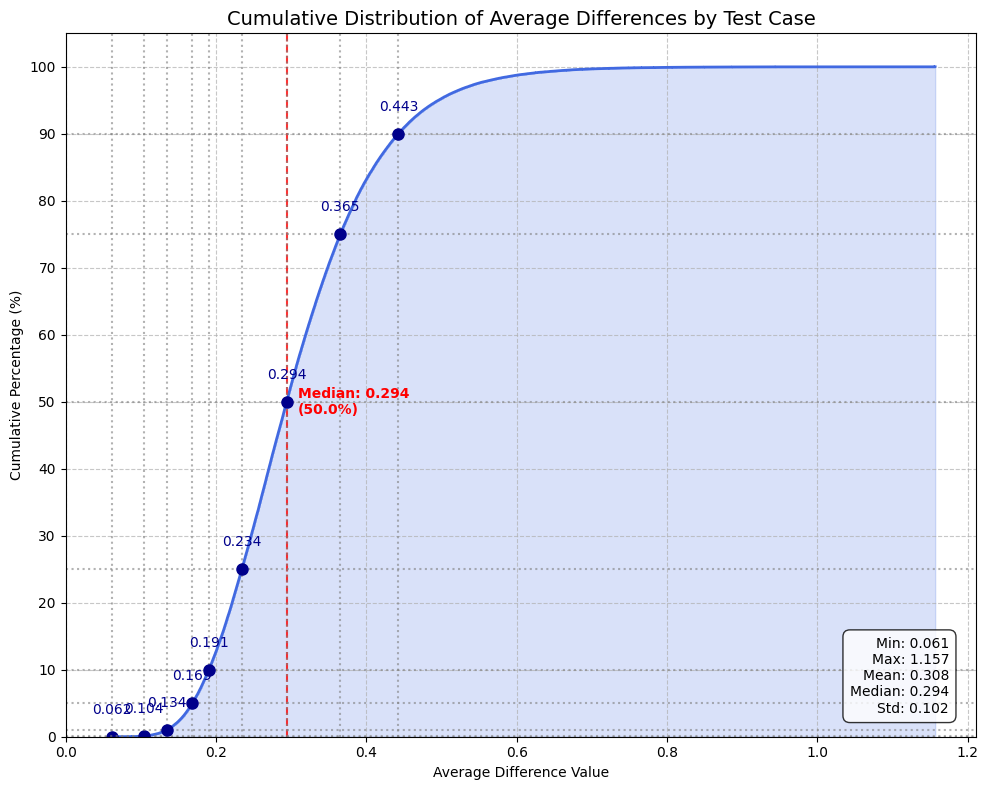

In [ ]:
layer_stats_df = pd.read_csv(f'{MODEL_NAME}_model_random_paths_for_{CLASSES[THE_CLASS]}_and_{K_ROUND}_Rounds.csv')

test_case_avg = layer_stats_df.groupby(['image_id', 'round'])['mean_cross_model_difference'].sum().reset_index()


plt.figure(figsize=(10, 8))

sorted_data = test_case_avg['mean_cross_model_difference'].sort_values()

y_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100

plt.step(sorted_data, y_values, where='post', color='royalblue', linewidth=2)
plt.fill_between(sorted_data, y_values, alpha=0.2, color='royalblue', step='post')

median_value = sorted_data.median()
median_idx = np.searchsorted(sorted_data, median_value)
median_y = y_values[min(median_idx, len(y_values)-1)]

plt.axvline(x=median_value, color='red', linestyle='--', alpha=0.8)
plt.text(median_value*1.05, 50, f"Median: {median_value:.3f}\n({median_y:.1f}%)", 
        color='red', ha='left', va='center', fontweight='bold')

percentiles = [0.0001,0.1,1,5,10,25, 50, 75, 90]
for pct in percentiles:
    percentile_value = sorted_data.quantile(pct/100)
    plt.axhline(y=pct, color='gray', linestyle=':', alpha=0.6)
    plt.axvline(x=percentile_value, color='gray', linestyle=':', alpha=0.6)
    plt.plot(percentile_value, pct, marker='o', color='darkblue', markersize=8)
    plt.text(percentile_value, pct+3, f"{percentile_value:.3f}", 
            color='darkblue', ha='center', va='bottom')


n_tests = len(sorted_data)

plt.grid(True, linestyle='--', alpha=0.7)
plt.title(f'Cumulative Distribution of Average Differences by Test Case',fontsize=14)#\nFor {classes[the_class]} and {model_info} Model (n={n_tests} test cases)', fontsize=14)
plt.xlabel('Average Difference Value')
plt.ylabel('Cumulative Percentage (%)')
plt.xlim(left=0)  # Start from 0
plt.ylim(0, 105)  # Percentage goes from 0 to 100%

plt.yticks(np.arange(0, 101, 10))


stats_text = (f"Min: {sorted_data.min():.3f}\n"
              f"Max: {sorted_data.max():.3f}\n"
              f"Mean: {sorted_data.mean():.3f}\n"
              f"Median: {median_value:.3f}\n"
              f"Std: {sorted_data.std():.3f}")

plt.text(0.97, 0.03, stats_text, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()

# Save plot
save_path = f'{MODEL_NAME}_model_differences_by_test_case_overall_for_{CLASSES[THE_CLASS]}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import math

layer_stats_df = pd.read_csv(f'{model_info}_model_random_paths_for_{classes[the_class]}_and_{K_ROUND}_Rounds.csv')
unique_layers = layer_stats_df['layer_name'].unique()
num_layers = len(unique_layers)
n_cols = min(3, num_layers) 
n_rows = math.ceil(num_layers / n_cols)




# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4), squeeze=False)
fig.suptitle(f'Cumulative Percentage Distribution of Differences Between {model_info} Models For {classes[the_class]}', 
             fontsize=16, y=0.98)

# Create a colormap
colors = plt.cm.viridis(np.linspace(0, 1, num_layers))

# Flatten the axes array for easy indexing
axes_flat = axes.flatten()

# Plot cumulative histogram for each layer in its own subplot
for i, layer in enumerate(unique_layers):
    if i >= len(axes_flat):  # Safety check
        break
        
    ax = axes_flat[i]
    layer_data = layer_stats_df[layer_stats_df['layer_name'] == layer]['mean_cross_model_difference'].sort_values()
    
    # Calculate ECDF values as percentages
    y_values = np.arange(1, len(layer_data) + 1) / len(layer_data) * 100
    
    # Plot the ECDF
    ax.step(layer_data, y_values, where='post', color=colors[i], linewidth=2)
    ax.fill_between(layer_data, y_values, alpha=0.2, color=colors[i], step='post')
    
    # Add median value as a vertical line with text annotation
    median_value = layer_data.median()
    median_idx = np.searchsorted(layer_data, median_value)
    median_y = y_values[min(median_idx, len(y_values)-1)]
    
    ax.axvline(x=median_value, color='red', linestyle='--', alpha=0.8)
    ax.text(median_value*1.05, 50, f"Median: {median_value:.3f}\n({median_y:.1f}%)", 
            color='red', ha='left', va='center', fontweight='bold')
    
    # Add markers at specific percentiles (25%, 50%, 75%, 90%)
    percentiles = [0.001,1,25, 50, 75, 90]
    for pct in percentiles:
        # Find the x value at the specified percentile
        percentile_value = layer_data.quantile(pct/100)
        ax.axhline(y=pct, color='gray', linestyle=':', alpha=0.6)
        ax.axvline(x=percentile_value, color='gray', linestyle=':', alpha=0.6)
        ax.plot(percentile_value, pct, marker='o', color='darkblue', markersize=6)
        ax.text(percentile_value, pct+3, f"{percentile_value:.3f}", 
                color='darkblue', ha='center', va='bottom', fontsize=8)
    
    # Add grid, title, and labels
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title(f'Layer: {layer}', fontsize=12)
    ax.set_xlabel('Difference Value')
    ax.set_ylabel('Cumulative Percentage (%)')
    ax.set_xlim(left=0)  # Start from 0
    ax.set_ylim(0, 105)  # Percentage goes from 0 to 100%
    
    # Add percentage y-ticks
    ax.set_yticks(np.arange(0, 101, 10))
    
    # Add statistics table in the corner
    stats_text = (f"Min: {layer_data.min():.3f}\n"
                  f"Max: {layer_data.max():.3f}\n"
                  f"Mean: {layer_data.mean():.3f}\n"
                  f"Median: {median_value:.3f}\n"
                  f"Std: {layer_data.std():.3f}")
    
    ax.text(0.97, 0.03, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Hide any unused subplots
for j in range(i+1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle

# Save plot
save_path = f'{model_info}_model_differences_cumulative_percent_by_layer_for_{classes[the_class]} and {model_info} Model.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Load the data
layer_stats_df = pd.read_csv(f'{model_info}_model_random_paths_for_{classes[the_class]}_and_{K_ROUND}_Rounds.csv')
model1_df = layer_stats_df[['layer_name', 'model1_activation_value']].copy()
model1_df['Model'] = 'Model 1'
if isinstance(model1_df['model1_activation_value'].iloc[0], str):
    model1_df['activation_value'] = model1_df['model1_activation_value'].apply(
        lambda x: float(x.strip('[]')))
else:
    model1_df['activation_value'] = model1_df['model1_activation_value']
model2_df = layer_stats_df[['layer_name', 'model2_activation_value']].copy()
model2_df['Model'] = 'Model 2'
if isinstance(model2_df['model2_activation_value'].iloc[0], str):
    model2_df['activation_value'] = model2_df['model2_activation_value'].apply(
        lambda x: float(x.strip('[]')))
else:
    model2_df['activation_value'] = model2_df['model2_activation_value']

combined_df = pd.concat([
    model1_df[['layer_name', 'Model', 'activation_value']],
    model2_df[['layer_name', 'Model', 'activation_value']]
])





fig, ax = plt.subplots(figsize=(32, 8))
sns.violinplot(data=combined_df, 
               x='layer_name', 
               y='activation_value',
               hue='Model',
               inner='quartile',
               density_norm='width',
               split=True,
               palette={'Model 1': 'royalblue', 'Model 2': 'darkorange'})

for i, layer in enumerate(combined_df['layer_name'].unique()):

    model1_data = combined_df[(combined_df['layer_name'] == layer) & 
                             (combined_df['Model'] == 'Model 1')]['activation_value']
    model1_mean = model1_data.mean()
    model1_median = model1_data.median()
    model1_q1 = model1_data.quantile(0.25)
    model1_q3 = model1_data.quantile(0.75)
    
    
    model2_data = combined_df[(combined_df['layer_name'] == layer) & 
                             (combined_df['Model'] == 'Model 2')]['activation_value']
    model2_mean = model2_data.mean()
    model2_median = model2_data.median()
    model2_q1 = model2_data.quantile(0.25)
    model2_q3 = model2_data.quantile(0.75)
    
    
    plt.text(i-0.2, model1_mean, f"μ={model1_mean:.2f}", 
             ha='right', va='center', fontweight='bold', color='royalblue', fontsize=8)
    
    
    plt.text(i+0.2, model2_mean, f"μ={model2_mean:.2f}", 
             ha='left', va='center', fontweight='bold', color='darkorange', fontsize=8)
    
    
    # stats_text = f"Model1: μ={model1_mean:.2f}, M={model1_median:.2f}\nModel2: μ={model2_mean:.2f}, M={model2_median:.2f}"
    # plt.text(i, ax.get_ylim()[0], stats_text, 
    #          ha='center', va='top', fontsize=7, 
    #          bbox=dict(facecolor='white', alpha=0.5, boxstyle='round',pad=0.5))

plt.xticks(rotation=45, ha='right')
plt.title(f'Distribution of Activation Values')#{model_info} - Model Activations For {classes[the_class]}')
plt.xlabel('Layer')
plt.ylabel('Activation Value')
#plt.ylim(0, 1e1)  # Adjust as needed

plt.tight_layout()

# Save plot
save_path = f'{model_info}_model_activations_violin_plot_for_{classes[the_class]}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# # Create a separate plot for the differences
# plt.figure(figsize=(16, 8))
# sns.violinplot(data=layer_stats_df, 
#                x='layer_name', 
#                y='mean_cross_model_difference',
#                inner='quartile',
#                density_norm='area',
#                color='red')

# # Customize plot
# plt.xticks(rotation=45, ha='right')
# plt.title(f'Distribution of Differences Between {model_info} - Models For {classes[the_class]}')
# plt.xlabel('Layer')
# plt.ylabel('Difference')
# #plt.ylim(0, 1e1)  # Adjust as needed

# plt.tight_layout()

# save_path = f'{model_info}_model_differences_violin_plot_for_{classes[the_class]}.png'
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
# plt.show()

print("Minimum values for each layer:")
for layer in layer_stats_df['layer_name'].unique():
    min_value = layer_stats_df[layer_stats_df['layer_name'] == layer]['mean_cross_model_difference'].min()
    print(f"{layer}: {min_value:.6e}")


In [ ]:
# Load the data
layer_stats_df = pd.read_csv(f'{model_info}_model_random_paths_for_{classes[the_class]}_and_{K_ROUND}_Rounds.csv')

# Process model1 data
model1_df = layer_stats_df[['layer_name', 'model1_activation_value']].copy()
model1_df['model'] = 'model1'
if isinstance(model1_df['model1_activation_value'].iloc[0], str):
    model1_df['activation_value'] = model1_df['model1_activation_value'].apply(
        lambda x: float(x.strip('[]')))
else:
    model1_df['activation_value'] = model1_df['model1_activation_value']

# Process model2 data
model2_df = layer_stats_df[['layer_name', 'model2_activation_value']].copy()
model2_df['model'] = 'model2'
if isinstance(model2_df['model2_activation_value'].iloc[0], str):
    model2_df['activation_value'] = model2_df['model2_activation_value'].apply(
        lambda x: float(x.strip('[]')))
else:
    model2_df['activation_value'] = model2_df['model2_activation_value']

# Combine the dataframes
combined_df = pd.concat([
    model1_df[['layer_name', 'model', 'activation_value']],
    model2_df[['layer_name', 'model', 'activation_value']]
])

# Function to calculate KL divergence between two distributions
def calculate_kl_divergence(p_values, q_values, bins=100, epsilon=1e-10):

    min_val = min(np.min(p_values), np.min(q_values))
    max_val = max(np.max(p_values), np.max(q_values))
    bin_edges = np.linspace(min_val, max_val, bins+1)
    p_hist, _ = np.histogram(p_values, bins=bin_edges, density=True)
    q_hist, _ = np.histogram(q_values, bins=bin_edges, density=True)
    p_hist = p_hist + epsilon
    q_hist = q_hist + epsilon
    p_hist = p_hist / np.sum(p_hist)
    q_hist = q_hist / np.sum(q_hist)
    
    # Calculate KL divergence: sum(p_i * log(p_i / q_i))
    kl = np.sum(p_hist * np.log(p_hist / q_hist))
    
    return kl

# Calculate KL divergence for each layer
unique_layers = combined_df['layer_name'].unique()
kl_results = []

for layer in unique_layers:
    layer_data = combined_df[combined_df['layer_name'] == layer]
    
    model1_values = layer_data[layer_data['model'] == 'model1']['activation_value'].values
    model2_values = layer_data[layer_data['model'] == 'model2']['activation_value'].values
    
    # Calculate KL divergence in both directions
    kl_model1_to_model2 = calculate_kl_divergence(model1_values, model2_values)
    kl_model2_to_model1 = calculate_kl_divergence(model2_values, model1_values)
    
    symmetric_kl = (kl_model1_to_model2 + kl_model2_to_model1)/2
    
    kl_results.append({
        'layer_name': layer,
        'kl_model1_to_model2': kl_model1_to_model2,
        'kl_model2_to_model1': kl_model2_to_model1,
        'symmetric_kl': symmetric_kl
    })

# Convert to DataFrame
kl_df = pd.DataFrame(kl_results)

# Sort by layer name (assuming names have numeric parts like 'layer1', 'layer2', etc.)
try:
    # Extract numeric part from layer name and sort
    kl_df['layer_num'] = kl_df['layer_name'].str.extract('(\d+)').astype(float)
    kl_df = kl_df.sort_values('layer_num').drop('layer_num', axis=1)
except:
    # If extraction fails, sort alphabetically
    kl_df = kl_df.sort_values('layer_name')

# Display the results
print(kl_df)

# Save the results to CSV
kl_df.to_csv(f'{model_info}_KL_divergence_by_layer_for_{classes[the_class]}.csv', index=False)

# Create a bar plot of KL divergence by layer
plt.figure(figsize=(14, 8))

# Plot both directional KL divergences
x = np.arange(len(kl_df))
width = 0.35

plt.bar(x - width, kl_df['kl_model1_to_model2'], width, label='KL(Model1 || Model2)', color='royalblue', alpha=0.7)
plt.bar(x, kl_df['kl_model2_to_model1'], width, label='KL(Model2 || Model1)', color='darkorange', alpha=0.7)
plt.bar(x+width, kl_df['symmetric_kl'], width, label='Symmetric KL Divergence', color='purple', alpha=0.7)

# Add layer names as x-tick labels
plt.xticks(x, kl_df['layer_name'], rotation=45, ha='right')
plt.xlabel('Layer')
plt.ylabel('KL Divergence')
plt.title(f'KL Divergence Between {model_info} Model Activations by Layer\nFor {classes[the_class]}', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig(f'{model_info}_KL_divergence_by_layer_for_{classes[the_class]}.png', dpi=300, bbox_inches='tight')
plt.show()

KL Divergence Results (Aggregated by img_id and round):
KL(Model 1 || Model 2): 2.0688
KL(Model 2 || Model 1): 2.1487
Symmetric KL: 2.1088


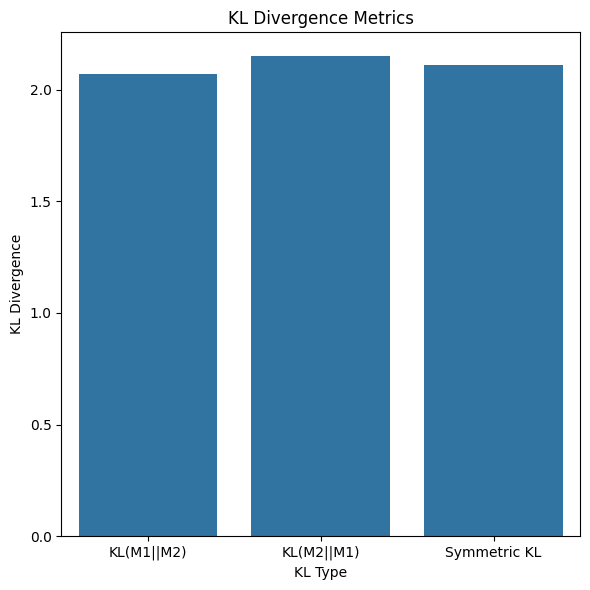

In [ ]:
# Load the data
layer_stats_df = pd.read_csv(f'{model_info}_model_random_paths_for_{classes[the_class]}_and_{K_ROUND}_Rounds.csv')

# Convert string representations to float if needed
if isinstance(layer_stats_df['model1_activation_value'].iloc[0], str):
    layer_stats_df['model1_activation_value'] = layer_stats_df['model1_activation_value'].apply(
        lambda x: float(x.strip('[]')))
    
if isinstance(layer_stats_df['model2_activation_value'].iloc[0], str):
    layer_stats_df['model2_activation_value'] = layer_stats_df['model2_activation_value'].apply(
        lambda x: float(x.strip('[]')))

# Directly aggregate by img_id and round
aggregated_df = layer_stats_df.groupby(['image_id', 'round']).agg({
    'model1_activation_value': 'mean',
    'model2_activation_value': 'mean'
}).reset_index()

kl_m1_to_m2 = calculate_kl_divergence(aggregated_df['model1_activation_value'],
                                      aggregated_df['model2_activation_value'])

kl_m2_to_m1 = calculate_kl_divergence(aggregated_df['model2_activation_value'],
                                      aggregated_df['model1_activation_value'])

symmetric_kl = (kl_m1_to_m2 + kl_m2_to_m1)/2


# Print results
print(f"KL Divergence Results (Aggregated by img_id and round):")
print(f"KL(Model 1 || Model 2): {kl_m1_to_m2:.4f}")
print(f"KL(Model 2 || Model 1): {kl_m2_to_m1:.4f}")
print(f"Symmetric KL: {symmetric_kl:.4f}")

# Create a histogram to visualize the aggregated activation distributions
plt.figure(figsize=(6, 6))

#plt.subplot(1, 2, 1)
# plt.hist(aggregated_df['model1_activation_value'], bins=30, alpha=0.7, label='Model 1')
# plt.hist(aggregated_df['model2_activation_value'], bins=30, alpha=0.7, label='Model 2')
# plt.xlabel('Activation Value')
# plt.ylabel('Frequency')
# plt.title('Distribution of Aggregated Activation Values')
# plt.legend()

# plt.subplot(1, 2, 2)
data = pd.DataFrame({
    'KL Type': ['KL(M1||M2)', 'KL(M2||M1)', 'Symmetric KL'],
    'Value': [kl_m1_to_m2, kl_m2_to_m1, symmetric_kl]
})
sns.barplot(x='KL Type', y='Value', data=data)
plt.title('KL Divergence Metrics')
plt.ylabel('KL Divergence')

plt.tight_layout()
plt.savefig(f'{model_info}_aggregated_kl_divergence_for_{classes[the_class]}.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the aggregated data and KL results
aggregated_df.to_csv(f'{model_info}_aggregated_activations_for_{classes[the_class]}.csv', index=False)

kl_results_df = pd.DataFrame({
    'metric': ['KL(Model 1||Model 2)', 'KL(Model 2||Model 1)', 'Symmetric KL'],
    'value': [kl_m1_to_m2, kl_m2_to_m1, symmetric_kl]
})
kl_results_df.to_csv(f'{model_info}_aggregated_kl_results_for_{classes[the_class]}.csv', index=False)